In [7]:
import os, sys
import numpy as np
from astropy import units
from astropy.io import fits
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from astropy.table import Table, Column
from scipy.optimize import minimize, curve_fit
from lightkurve.lightcurve import LightCurve
from scipy.signal import find_peaks, gaussian
from scipy.interpolate import interp1d
from lmfit import Model

import theano
import exoplanet as xo
import pymc3 as pm
import theano.tensor as tt

from stella.utils import flare_lightcurve

%load_ext autoreload
%autoreload 2
sys.path.append('/Users/arcticfox/Documents/GitHub/cos_flares/src/')
from utils import *
from cos_flares import FlaresWithCOS

## PROPOSAL ID 16164
plt.rcParams['font.size']=18

wavelength, flux, err = load_binned_data('/Users/arcticfox/Documents/AUMic/reduced/binned_data_a.npy')
wavelength2, flux2, err2 = load_binned_data('/Users/arcticfox/Documents/AUMic/reduced2/binned_data2.npy')

times = np.load('/Users/arcticfox/Documents/AUMic/reduced/times.npy')
orbits = np.load('/Users/arcticfox/Documents/AUMic/reduced/orbits.npy')
times2 = np.load('/Users/arcticfox/Documents/AUMic/reduced2/times.npy')
orbits2 = np.load('/Users/arcticfox/Documents/AUMic/reduced2/orbits.npy')+5

wavelength = np.full(flux.shape, wavelength)
wavelength2 = np.full(flux2.shape, wavelength2)

_, flare_orbits, flare_mask = np.load('/Users/arcticfox/Documents/AUMic/flare_mask.npy',
                                      allow_pickle=True)

parula = np.load('/Users/arcticfox/parula_colors.npy')

distance = (9.79*units.pc).to(units.cm)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
fwc = FlaresWithCOS(wavelength=np.append(wavelength, wavelength2, axis=0), 
                    flux=np.append(flux, flux2, axis=0),
                    flux_err=np.append(err, err2, axis=0), 
                    time=np.append(times, times2)-times[0], 
                    orbit=np.append(orbits, orbits2))
fwc.load_line_table(path='/Users/arcticfox/Documents/GitHub/cos_flares/')
fwc.load_lsf_model(fname='/Users/arcticfox/Documents/AUMic/aa_LSFTable_G130M_1222_LP4_cn.dat')

main_ions = ['SiII', 'SiIII', 'CIII', 'FeXXI']
ion_color = ['#352a87', '#0e76dc', '#07a9c3','#e4b950']

## Line fitting

SiII


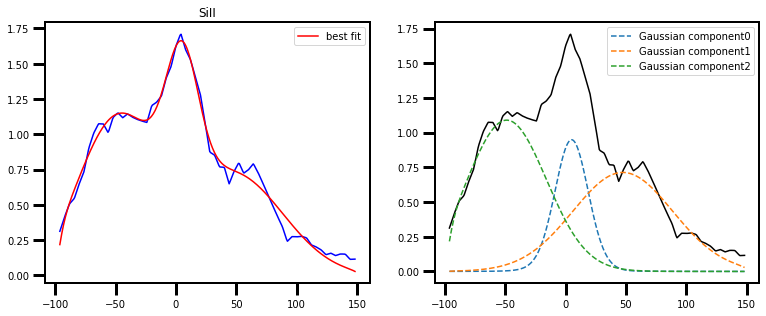

SiIII


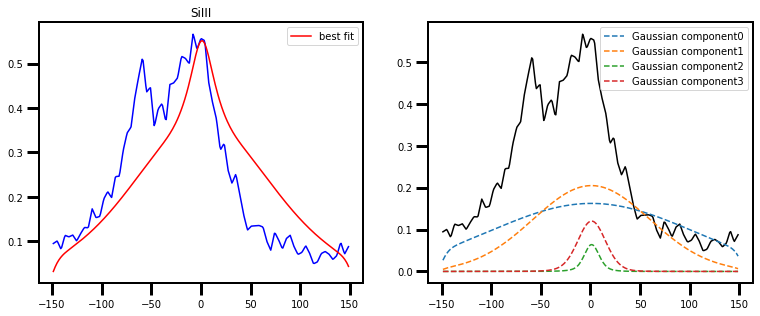

CIII


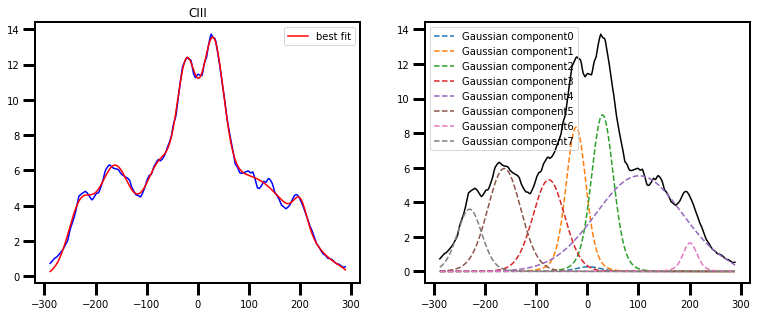

FeXXI


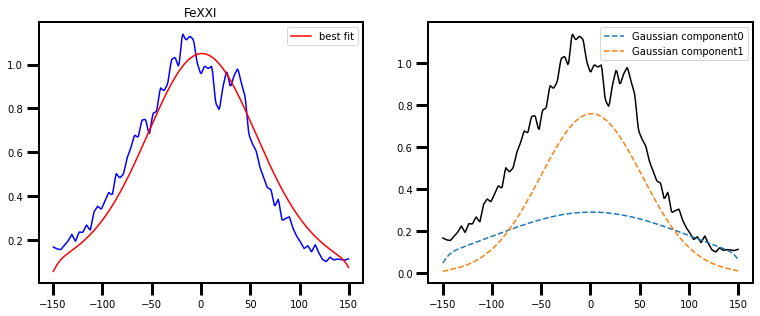

In [3]:
oot = np.nansum(flare_mask, axis=0)==0

oof_values = []

for i in range(len(main_ions)):
    ngauss = fwc.line_table[fwc.line_table['ion']==main_ions[i]]['ngauss'].data[0]+0
    
    if i == 0:
        ngauss = 3
    elif i == 1:
        ngauss = 4
    elif i == 2:
        ngauss = 8
        

    print(main_ions[i])
    args = fwc.model_line_shape(ion=main_ions[i],
                                mask=oot, 
                                ngauss=ngauss, 
                                ext=50)
    oof_values.append(args)
    
    fig, axes = plt.subplots(1, 2, figsize=(12.8, 4.8))
    axes[0].plot(args[0], args[1], 'b')
    #axes[0].plot(vel, init, 'k--', label='initial fit')
    axes[0].plot(args[0], args[-1].best_fit, 'r-', label='best fit')
    axes[0].legend(loc='best')
    axes[0].set_title(main_ions[i])
    comps = args[-1].eval_components(x=args[0])
    axes[1].plot(args[0], args[1], 'k')
    for i in range(ngauss):
        axes[1].plot(args[0], comps['g{}_'.format(i)], '--', label='Gaussian component'+str(i))
    axes[1].legend(loc='best')
    plt.show()

In [4]:
oof_values[-1][-1]

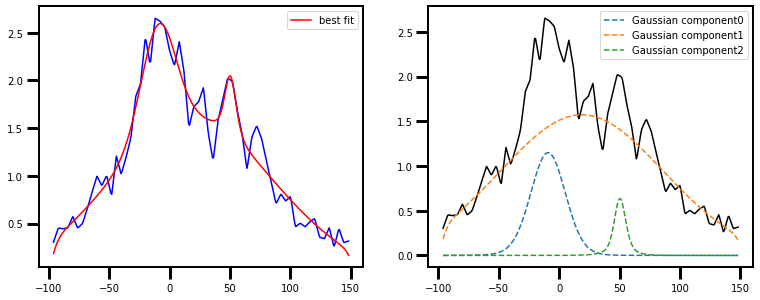

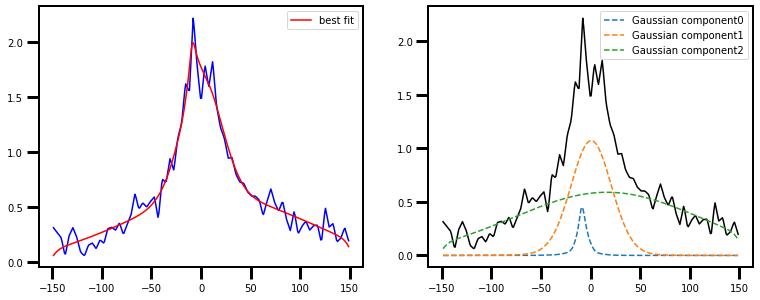

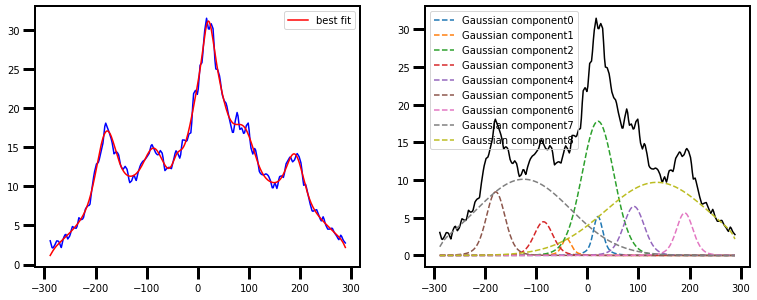

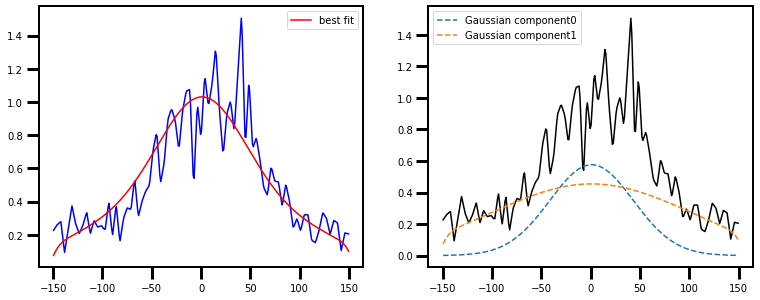

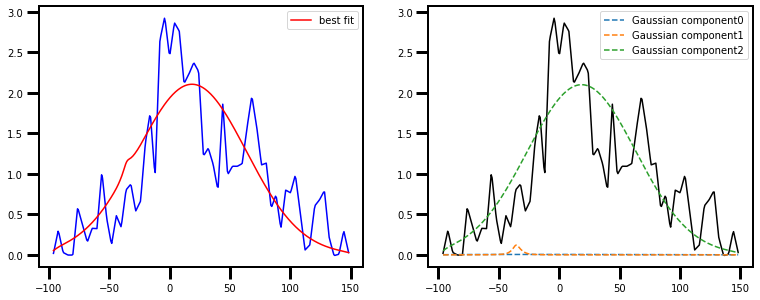

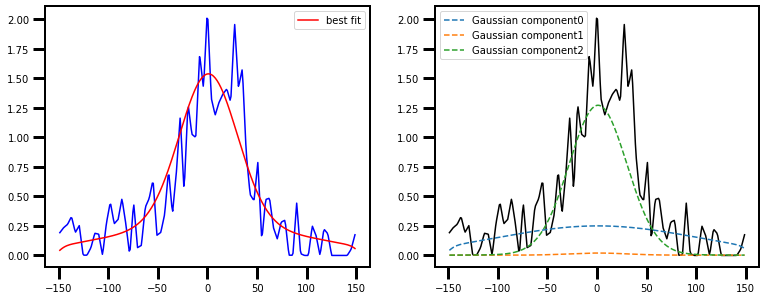

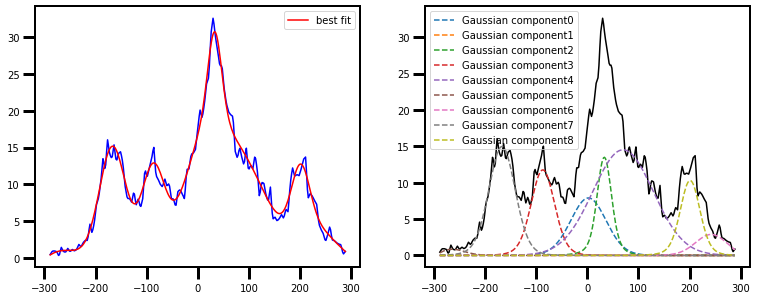

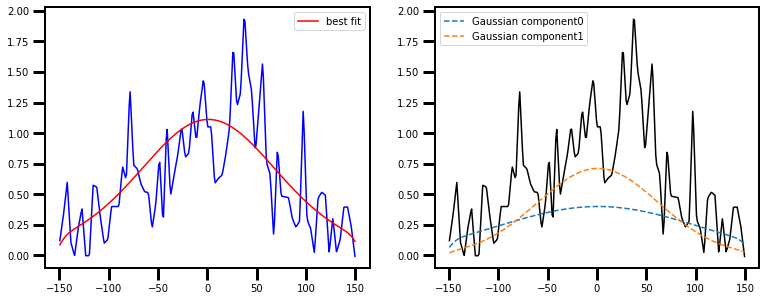

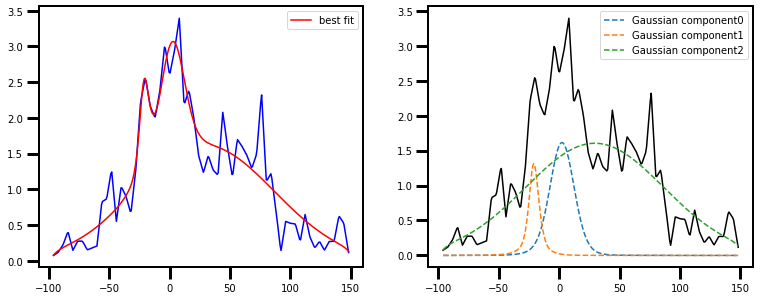

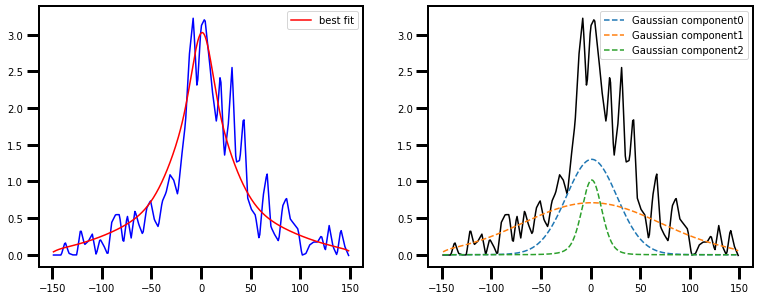

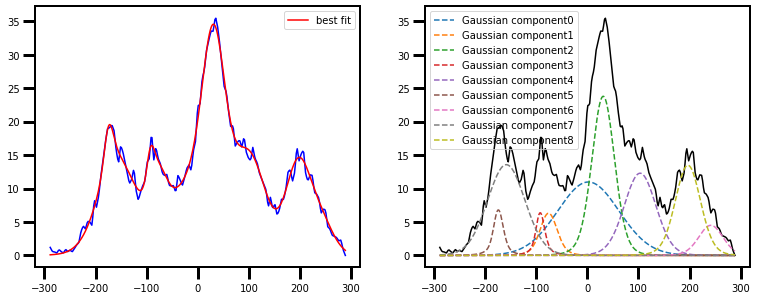

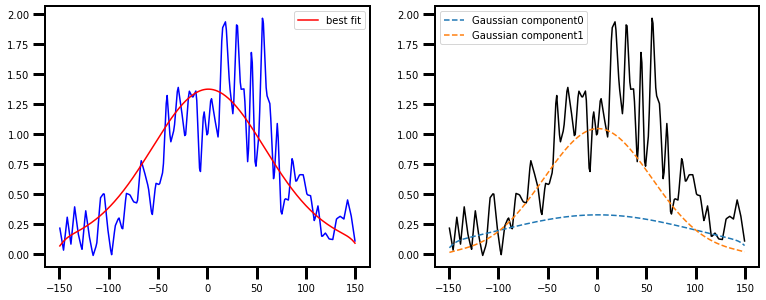

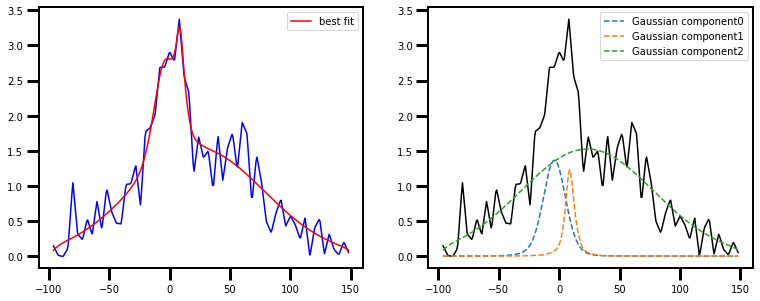

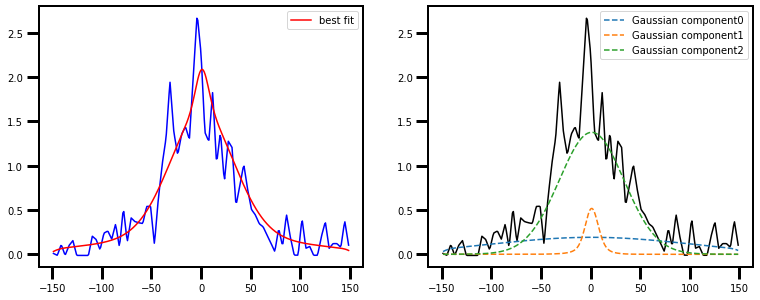

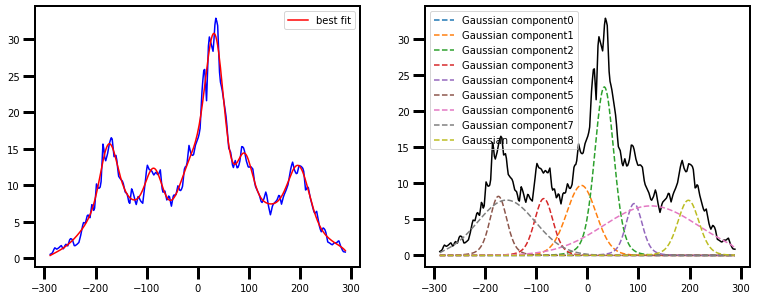

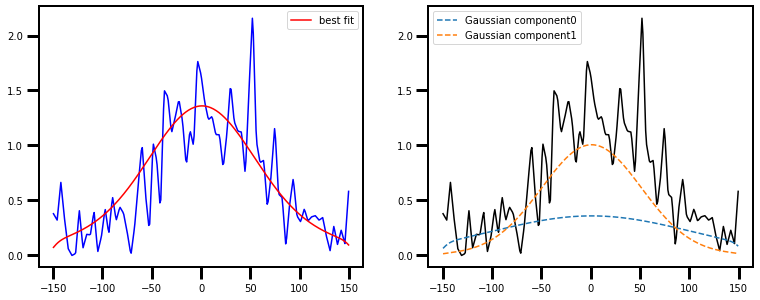

In [5]:
ngauss=4

it_masks = [flare_mask[2]>0,
            flare_mask[-4]>0,
            flare_mask[-3]>0,
            flare_mask[-1]>0]

if_values = []

for m in it_masks:
    temp = []
    for i in range(len(main_ions)):
        ngauss = fwc.line_table[fwc.line_table['ion']==main_ions[i]]['ngauss'].data[0]+0

        if i == 1 or i == 0:
            ngauss = 3
        if i == 2:
            ngauss = 9

        args = fwc.model_line_shape(ion=main_ions[i],
                                    mask=m, 
                                    ngauss=ngauss,
                                    ext=50)

        fig, axes = plt.subplots(1, 2, figsize=(12.8, 4.8))
        axes[0].plot(args[0], args[1], 'b')
        #axes[0].plot(vel, init, 'k--', label='initial fit')
        axes[0].plot(args[0], args[-1].best_fit, 'r-', label='best fit')
        axes[0].legend(loc='best')

        comps = args[-1].eval_components(x=args[0])
        axes[1].plot(args[0], args[1], 'k')
        for i in range(ngauss):
            axes[1].plot(args[0], comps['g{}_'.format(i)], '--', label='Gaussian component'+str(i))
        axes[1].legend(loc='best')
        plt.show()
        temp.append(args)
    if_values.append(temp)

TypeError: unsupported operand type(s) for *: 'NoneType' and 'int'

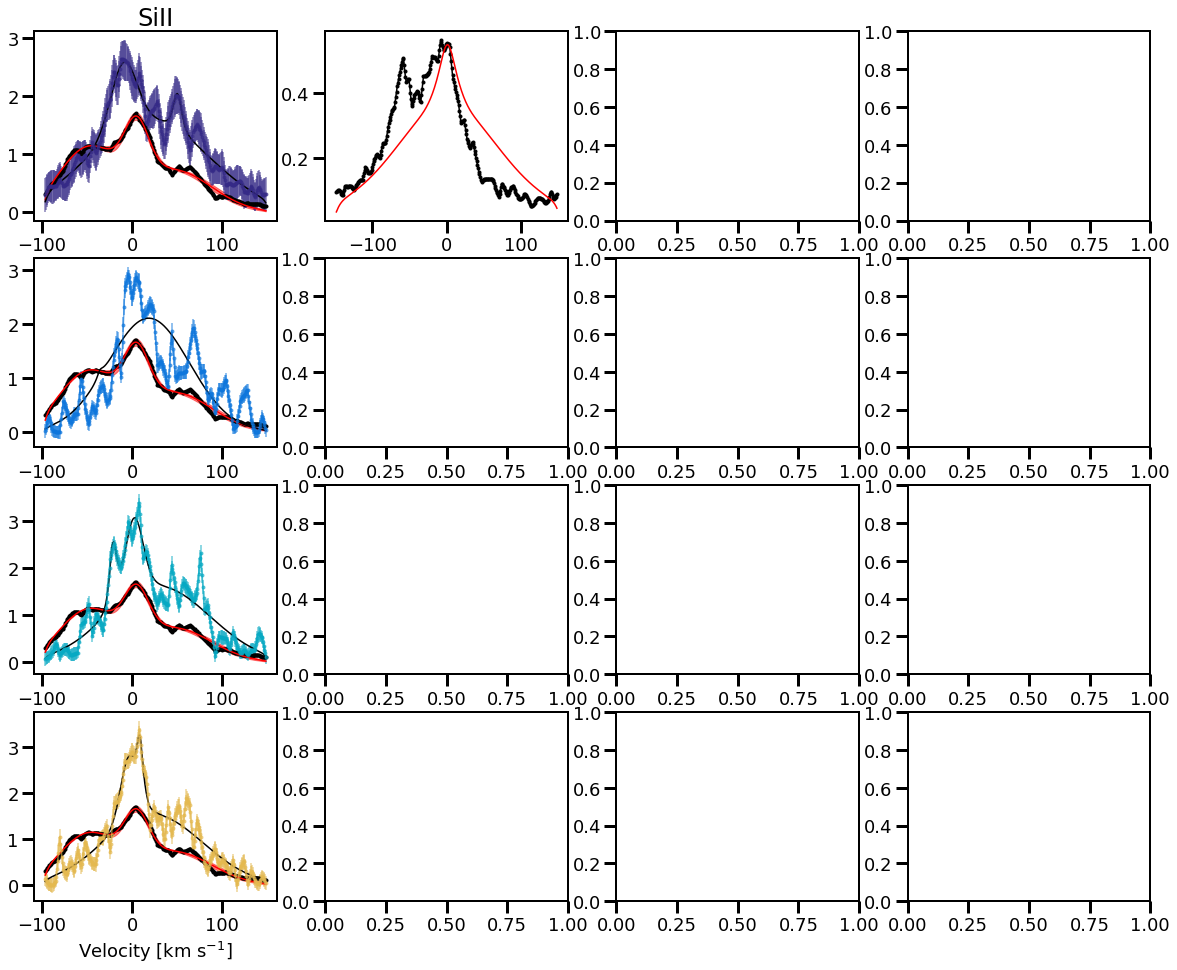

In [8]:
fig, axes = plt.subplots(ncols=4, nrows=4, figsize=(20,16))
fig.set_facecolor('w')
lw = 3
i = 0
ions = ['SiII', 'SiIII', 'CIII', 'FeXXI']

ax = axes.reshape(-1)
f1 = ax[:5]
f2 = ax[4:9]
f3 = ax[8:12]
f4 = ax[12:]

fs = [ f1,f2,f3,f4]

for i in range(4):
    for j in range(4):
        
        fs[j][i].plot(oof_values[i][0], oof_values[i][1],
                      c='k', marker='.')
        fs[j][i].plot(oof_values[i][0], oof_values[i][-1].best_fit,
                      c='r')
        
        up = build_lmfit(oof_values[i][0], params=oof_values[i][-1].params,
                         lsf=oof_values[i][3], std=1)

        lo = build_lmfit(oof_values[i][0], params=oof_values[i][-1].params,
                         lsf=oof_values[i][3], std=-1)
        fs[j][i].fill_between(oof_values[i][0], lo, up, alpha=0.5, color='r')

        
        fs[j][i].errorbar(if_values[j][i][0], if_values[j][i][1], yerr=if_values[j][i][2]/10,
                      c=ion_color[j], marker='.', alpha=0.6)
        fs[j][i].plot(if_values[j][i][0], if_values[j][i][-1].best_fit, 
                      c='k')
        
        
        
        if j == 0:
            fs[j][i].set_title(main_ions[i], fontsize=24)
        if j == 3:
            fs[j][i].set_xlabel('Velocity [km s$^{-1}$]')
    #f2[i].plot(if_values[0][i][0], if_values[0][i][1], c=ion_color[1])
    #f3[i].plot(if_values[0][i][0], if_values[0][i][1], c=ion_color[2])
    #f4[i].plot(if_values[0][i][0], if_values[0][i][1], c=ion_color[3])

In [ ]:
m = build_lmfit(oof_values[0][0], params=oof_values[0][-1].params,
            lsf=fwc.lsf_table['1077.0'], std=1)
plt.plot(oof_values[0][0], m)

m = build_lmfit(oof_values[0][0], params=oof_values[0][-1].params,
            lsf=fwc.lsf_table['1077.0'], std=-1)
plt.plot(oof_values[0][0], m)

In [ ]:
if_values[1][1][-1]